In [1]:
#importing stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Complete cell to create money metrics df for merging

#importing data from csz
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie_budgets_df

#renaming it to work on
money_metrics_df = tn_movie_budgets_df

#funtion for cleaning
def clean_a_money_column(df, series_title):
    df[series_title] = df[series_title].str.replace('$','')
    df[series_title] = df[series_title].str.replace(',','')
    df[series_title] = pd.to_numeric(df[series_title])
    return df

#cleaning
money_metrics_df = clean_a_money_column(money_metrics_df,'worldwide_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'domestic_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'production_budget')


##Unique ID for later merging madness

money_metrics_df['mmdf_uni_id'] = money_metrics_df.index



#adding profit margin and ROI columns
money_metrics_df['Profit Margin']= (money_metrics_df['worldwide_gross']-money_metrics_df['production_budget'])/money_metrics_df['worldwide_gross']
money_metrics_df['ROI'] = (money_metrics_df['worldwide_gross']/money_metrics_df['production_budget'])

#setting profit margin desc as order for the table
money_metrics_df=money_metrics_df.sort_values(['Profit Margin'], ascending=False)

#dropping the zeros gross films

money_metrics_df = money_metrics_df[money_metrics_df['worldwide_gross'] != 0]

#creating year and month columns
#Vu's magic lambda, plus to numeric on the year 
money_metrics_df['Year'] = pd.to_numeric(money_metrics_df['release_date'].map(lambda x: x[-4:]))
money_metrics_df['Month'] = money_metrics_df['release_date'].map(lambda x: x[:3])

#I did this at some point and it breaks if I don't do it here
money_metrics_df.set_index('movie', inplace = True)
money_metrics_df.index.rename('Movie', inplace = True)

#vu's dupe check
movie_dupes = pd.Series(tn_movie_budgets_df['movie'].value_counts())
title_dupes = [movie_dupes.index[index] for index in list(range(len(movie_dupes))) if movie_dupes.values[index] > 1]


#making a new df to do the rename in
title_dupes_df = money_metrics_df[money_metrics_df.index.isin(title_dupes)].copy()

#reset the index for easier editing
title_dupes_df.reset_index(inplace = True)

title_dupes_df.head(5)

#Making new columns, setting year to string for concat
title_dupes_df['Yearasastring'] = title_dupes_df['Year'].map(lambda x: str(x))
#Making the new title by combining the name of the movie and the year of release
title_dupes_df['New Title'] = title_dupes_df['Movie']+' '+title_dupes_df['Yearasastring'].copy()
#creating a new DF dropping all the columns we don't need 
title_dupes_df_merger = title_dupes_df[['mmdf_uni_id', 'New Title']]
#Don't actually know if we need this but, whatever.
money_metrics_df.reset_index(inplace = True)


#reintegrating new titles in a new df mergedf
mergedf = money_metrics_df.merge(title_dupes_df_merger, on = 'mmdf_uni_id', how= 'left')

#vu's slightly less magical de-duplicator

#new column for boolean
mergedf['is_title_NaN'] = mergedf['New Title'].isnull()

#for loop to rename 'Movie'
for movie_index in list(range(len(mergedf.index))):
    if  ~mergedf['is_title_NaN'][movie_index]:
        mergedf['Movie'][movie_index] = mergedf['New Title'][movie_index]

        
money_metrics_merge_ready = mergedf   


#### NOW OUTPUTS A DF CALLED money_metrics_merge_ready
#### TRY TO NOT MESS WITH THIS BLOCK, MAKE A COPY OF money_metrics_merge_ready
#### AND MESS WITH THAT        



<ipython-input-2-66c18aa4fffb>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mergedf['Movie'][movie_index] = mergedf['New Title'][movie_index]


In [3]:
months_and_years_df = money_metrics_merge_ready
months_and_years_df


,Movie,id,release_date,production_budget,domestic_gross,worldwide_gross,mmdf_uni_id,Profit Margin,ROI,Year,Month,New Title,is_title_NaN
0,Deep Throat,46,"Jun 30, 1972",25000,45000000,45000000,5745,0.999444,1800.000000,1972,Jun,NaN,True
1,Mad Max,14,"Mar 21, 1980",200000,8750000,99750000,5613,0.997995,498.750000,1980,Mar,NaN,True
2,Paranormal Activity,93,"Sep 25, 2009",450000,107918810,194183034,5492,0.997683,431.517853,2009,Sep,NaN,True
3,The Gallows,80,"Jul 10, 2015",100000,22764410,41656474,5679,0.997599,416.564740,2015,Jul,NaN,True
4,The Blair Witch Project,7,"Jul 14, 1999",600000,140539099,248300000,5406,0.997584,413.833333,1999,Jul,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410,Food Chains,36,"Nov 21, 2014",913000,0,176,5335,-5186.500000,0.000193,2014,Nov,NaN,True
5411,The Grimm Brothers' Snow White,53,"Aug 24, 1997",26000000,5000,5000,2152,-5199.000000,0.000192,1997,Aug,NaN,True
5412,Skin Trade,19,"May 8, 2015",9000000,1242,1242,3818,-7245.376812,0.000138,2015,May,NaN,True
5413,Perrierâs Bounty,82,"May 21, 2010",6600000,828,828,4081,-7970.014493,0.000125,2010,May,NaN,True


In [55]:
#A BLOCK OF USEFUL FUNCTIONS

#functions to pull years, months out of the data set. Can also be used for other column types?
#for now, use int types for the year
def year_iso (df, year):
    output_df = df[df['Year'] == year]
    return output_df

#for now, with money_metrics_df, use three letter abreviations for months
def month_iso (df, month):
    output_df = df[df['Month'] == month]
    return output_df

#A function to take any dataframe e.g. an isolated year, and get a monthly breakdown
def run_the_months(df):
    df_list=[]
    for i in month_list:
        month_abrev= i[0:3]
        data_frame_to_list = month_iso(df , month_abrev)
        df_list.append(data_frame_to_list)
        output_dict = dict(zip(month_list, df_list))
    
    
    
    return output_dict

#Automating year pull outs on money_metrics_merge_ready, not sure the best way to do this, but for now, list of dataframes?
#Setting keys = year
year_range = list(range(1915,2021))
year_range
year_keys = []
for i in year_range:
    year_keys.append(i)

list_of_dfs_years = []
for i in year_range:
    df_out = year_iso (months_and_years_df, i)
    list_of_dfs_years.append(df_out)
    
years_and_dfs = dict(zip(year_keys,list_of_dfs_years))

#if we want monthly data

jan_mmmr_df = month_iso(months_and_years_df,'Jan')
feb_mmmr_df = month_iso(months_and_years_df,'Feb')
mar_mmmr_df = month_iso(months_and_years_df,'Mar')
apr_mmmr_df = month_iso(months_and_years_df,'Apr')
may_mmmr_df = month_iso(months_and_years_df,'May')
jun_mmmr_df = month_iso(months_and_years_df,'Jun')
jul_mmmr_df = month_iso(months_and_years_df,'Jul')
aug_mmmr_df = month_iso(months_and_years_df,'Aug')
sep_mmmr_df = month_iso(months_and_years_df,'Sep')
oct_mmmr_df = month_iso(months_and_years_df,'Oct')
nov_mmmr_df = month_iso(months_and_years_df,'Nov')
dec_mmmr_df = month_iso(months_and_years_df,'Dec')

month_list= ['January','February','March', 'April', 'May','June','July','August',
                           'September','October','November','December']

months_and_dfs = dict(zip( ['January','February','March', 'April', 'May','June','July','August',
                           'September','October','November','December'],
                         [jan_mmmr_df, feb_mmmr_df,mar_mmmr_df,apr_mmmr_df,may_mmmr_df,jun_mmmr_df,
                          jul_mmmr_df, aug_mmmr_df, sep_mmmr_df, oct_mmmr_df, nov_mmmr_df, dec_mmmr_df]))

month_list

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

,Movie,id,release_date,production_budget,domestic_gross,worldwide_gross,mmdf_uni_id,Profit Margin,ROI,Year,Month,New Title,is_title_NaN
19,Billy Jack,58,"Jan 1, 1971",800000,98000000,98000000,5357,0.991837,122.500000,1971,Jan,NaN,True
26,The Devil Inside,12,"Jan 6, 2012",1000000,53262945,101759490,5211,0.990173,101.759490,2012,Jan,NaN,True
27,Sweet Sweetback's Baad Asssss Song,56,"Jan 1, 1971",150000,15200000,15200000,5655,0.990132,101.333333,1971,Jan,NaN,True
40,Eraserhead,82,"Jan 1, 1977",100000,7000000,7014590,5681,0.985744,70.145900,1977,Jan,NaN,True
54,Split,50,"Jan 20, 2017",5000000,138141585,278964806,4249,0.982077,55.792961,2017,Jan,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5358,Two Lovers and a Bear,75,"Jan 31, 2017",6840000,0,22273,4074,-306.098280,0.003256,2017,Jan,NaN,True
5360,All Hat,5,"Jan 18, 2008",4900000,15198,15198,4404,-321.410844,0.003102,2008,Jan,NaN,True
5380,B-Girl,95,"Jan 26, 2010",700000,0,1160,5394,-602.448276,0.001657,2010,Jan,NaN,True
5407,Ed and his Dead Mother,28,"Jan 1, 1993",1800000,673,673,5027,-2673.591382,0.000374,1993,Jan,NaN,True


AttributeError: 'NoneType' object has no attribute 'values'

In [56]:
#For loop to go through the months and take the mean ROI
mean_ROI_list= []

for i in months_and_dfs:
    mean_ROI_list.append(months_and_dfs[i]['ROI'].mean())
        
monthly_mean_ROI_dict=dict(zip(month_list, mean_ROI_list))    

In [57]:
years_and_dfs.keys()

dict_keys([1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [75]:
#getting some year by year data to layer onto the graph

#This is just getting the range for the for loop
post_2000 = list(range(2000,2021))

#setting up lists for key and value
key_list_2000 = []
value_list_2000 = []

#for loop to run the months on the years
for i in post_2000:
    key = 'The year ' + str(i) 
    i_df = years_and_dfs[i]
    value = run_the_months(i_df)
    key_list_2019.append(key)
    value_list_2019.append(value)
#there must be a way to do this in the dataframe    


post_2019_dict = dict(zip(key_list_2019 , value_list_2019))
#out puts a dict strucutured like so. 
#First layer of keys is 'The year ****' -> value is another dictionary
#that dictionary's keys are the months, and values, a dataframe of just that month of that year.

    
    

In [77]:
for i in post_2019_dict:
    

The year 2019
The year 2020
The year 2000
The year 2001
The year 2002
The year 2003
The year 2004
The year 2005
The year 2006
The year 2007
The year 2008
The year 2009
The year 2010
The year 2011
The year 2012
The year 2013
The year 2014
The year 2015
The year 2016
The year 2017
The year 2018


''

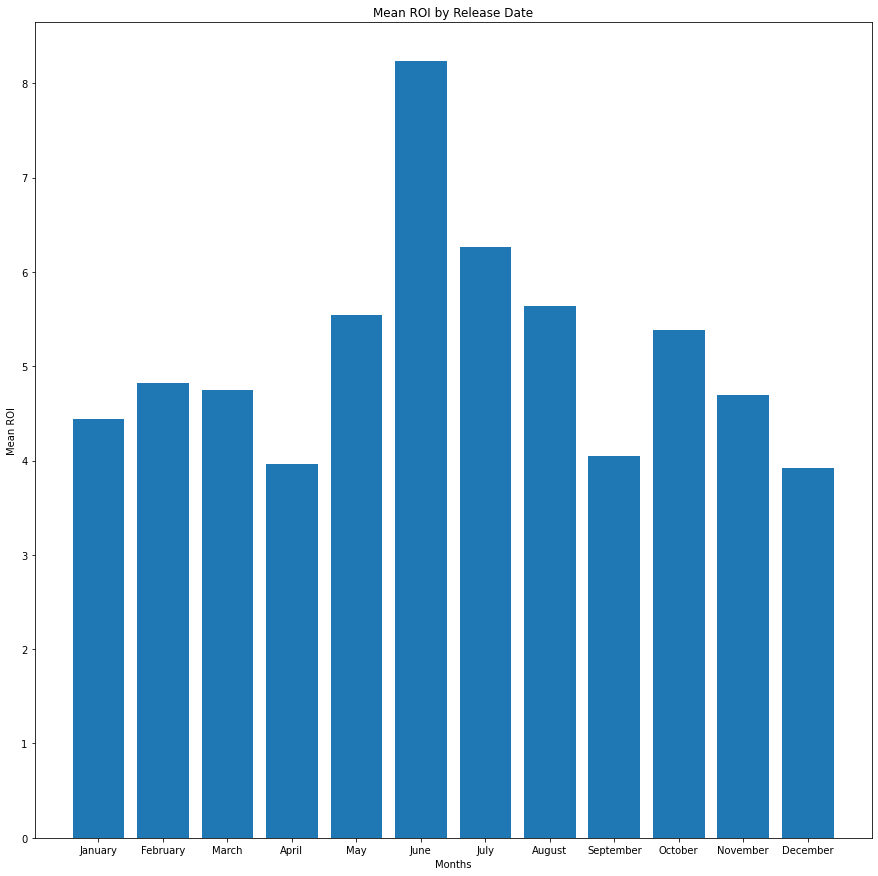

In [7]:
fig, ax = plt.subplots(figsize=(15,15))

ax.bar(monthly_mean_ROI_dict.keys(), monthly_mean_ROI_dict.values(), width=.8)
ax.set_xlabel('Months')
ax.set_ylabel('Mean ROI')
ax.set_title('Mean ROI by Release Date')



;
    